# Industry Entry and Exit

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 9.6.2

### 設定
* 期首に企業はその期に操業した場合の、短期の利潤 $\pi_t$ を観察する
* その期に操業するか否かを決める。操業した場合の利潤は $\pi_t$、しない場合は $0$
* 前期操業していて、今期操業をしない場合、shutdown cost $K_0$ がかかる
* 前期操業しておらず、今期操業する場合は、start-up cost $K_1$ がかかる
* 短期利潤は、外生的な確率変数を含むマルコフ過程に従う

状態変数は当期の短期利潤と、前期操業していたか否かである  
$\pi \in (-\infty, \infty)$  
$d \in \{0, 1\}$  
$d=1$ は操業していたことを、$d=0$ は操業していなかったことを示す

$\pi$ はマルコフ過程に従うので、  
$\pi_{t+1} = h \left( \pi_{t}, \epsilon_{t+1} \right)$  
と遷移すると表現される

行動変数は  
$x \in \{0, 1 \}$  
であり、$x=1$ は操業することを、$x=0$ は操業しないことを示す


Reward function は以下のようになる
$$
f \left(\pi, d, x \right) = \pi x - K_{1} \left(1-d\right)x - K_{0}d\left( 1-x \right)
$$

したがって、その期の利潤と前期の操業状態を与えられたときの企業の価値は、割り引き因子を $\delta$ として、以下のベルマン方程式に従う
$$
V\left( \pi, d\right) = \max_{x=0,1} \{ \pi x - K_{1} \left(1-d\right)x - K_{0}d\left(1-x\right) + \delta E_{\epsilon}V\left( h \left( \pi, \epsilon \right), x \right) \}
$$

しかし、このままでは value function が2変数関数になり、計算が難しく、分析もしづらい  
そこで、value function を $d$ の値に応じて2つにわける  
$d=1$のときは $V$、$d=0$ のときは $U$ とする

そうすると、$V$、$U$ は以下のベルマン方程式に従う
$$
V\left(\pi_{t}\right) = \max \{ \pi_{t} + \delta E_{\epsilon}V\left( h \left( \pi, \epsilon \right)\right),\   -K_{0} + \delta E_{\epsilon}U\left( h \left( \pi, \epsilon \right)\right) \}
$$
$$
U\left(\pi_{t}\right) = \max \{ \pi_{t} - K_{1} + \delta E_{\epsilon}V\left( h \left( \pi, \epsilon \right)\right),\   \delta E_{\epsilon}U\left( h \left( \pi, \epsilon \right)\right) \}
$$

上式の $\max$ の中の左側の項が今期操業した場合を、右側の項が今期操業しなかった場合を意味する

過去の操業状態と、現在の利潤によって、企業の価値がどうなるかを計算する

In [1]:
using QuantEcon
using Plots

$\pi$は具体的に以下のような形のマルコフ過程に従うと仮定する
$$
\pi_{t+1} = \bar{\pi} + \gamma \left( \pi_{t} - \bar{\pi} \right) + \epsilon_{t+1}
$$
$$
\epsilon_{t}, \  i.i.d. \sim N(0,  \sigma^{2})
$$

各パラメータを収める struct を作る

In [2]:
mutable struct IndustryEntry
    pibar::AbstractFloat # 翌期の profit に影響を与えるパラメータ
    gamma::AbstractFloat # 翌期の profit に影響を与えるパラメータ
    kentry::AbstractFloat # Entry cost
    kexit::AbstractFloat # Exit cost
    sigma::AbstractFloat # Variance of random shock
    delta::AbstractFloat # Discount factor
    p_vec::AbstractVector{AbstractFloat} # Profits grid
end

In [3]:
IE = IndustryEntry(0.0, 0.7, 10, 5, 1.0, 0.9, collect(linspace(-10, 10, 100)));

ベルマン方程式中に出てくる期待値の計算は本来は積分する必要があるが、コンピュータ上で積分計算は面倒(できない？)  
そこで、`QunatEcon` の `qnwnorm`という関数を用いて離散化する

`qnwnorm` を使えば、正規分布について離散化して、とりうる値とそれに対応するウェイトをだしてくれるので、
$$
E_{\epsilon}V\left( h \left( \pi, \epsilon \right)\right) = \int_{-\infty}^{\infty}V\left( h \left( \pi, \epsilon \right)\right) f(\epsilon)d\epsilon
$$
とすべきところを、
$$
E_{\epsilon}V\left( h \left( \pi, \epsilon \right)\right) \simeq \sum_{k=1}^{n} V\left( h \left( \pi, \epsilon_{k} \right)\right)w_{k}
$$
と置き換えて計算する

ただし、ここでの $f(\epsilon)$ は $\epsilon$ の確率密度関数である

In [4]:
# IE のベルマン方程式を更新する関数
function update_bellman(IE::IndustryEntry, V::Vector, U::Vector)
    pibar, g, k1, k0, s, d = IE.pibar, IE.gamma, IE.kentry, IE.kexit, IE.sigma, IE.delta
    V_func = LinInterp(IE.p_vec, V)
    U_func = LinInterp(IE.p_vec, U)
    V_new = similar(V)
    U_new = similar(U)
    e, w = qnwnorm(5, 0, s)
    
    for (p_idx, p) in enumerate(IE.p_vec)
        V_new[p_idx] = max(p + d * dot(V_func.(e .+ pibar .+ (g*(p-pibar))), w),
                           -k0 + d * dot(U_func.(e .+ pibar .+ (g*(p-pibar))), w))
    end
    
    for (p_idx, p) in enumerate(IE.p_vec)
        U_new[p_idx] = max(p - k1 + d * dot(V_func.(e .+ pibar .+ (g*(p-pibar))), w),
                           d * dot(U_func.(e .+ pibar .+ (g*(p-pibar))), w))
    end
    
    return V_new, U_new
end

update_bellman (generic function with 1 method)

各短期利潤ごとに適当な価値を割り振り、そこからベルマン方程式を繰り返し更新する

In [5]:
# Initial guess
V = zeros(length(IE.p_vec))
U = ones(length(IE.p_vec));

In [6]:
V_computed = copy(V)
U_computed = copy(U)
for i in 1:500
    V_computed, U_computed = update_bellman(IE, V_computed, U_computed)
end


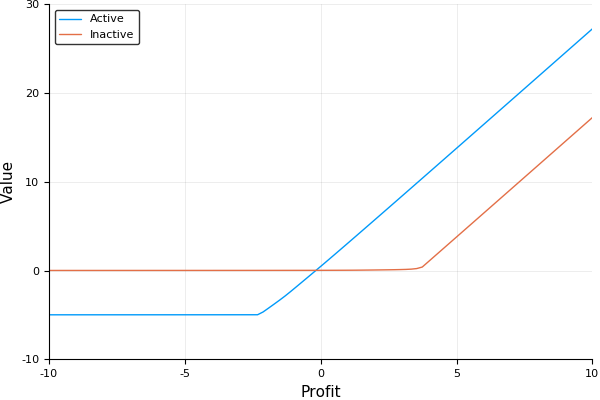

In [7]:
plot(IE.p_vec, [V_computed U_computed], label=["Active" "Inactive"],
     xlabel="Profit", ylabel="Value", ylims=(-10, 30), yticks=-10:10:30)

上図でシャープに右肩上がりになっている範囲では今期操業し、ほぼ一定になっているところでは操業しないという選択をしていると考えられる

前期の状態ごとに、どのあたりが操業の分岐点になっているかを調べる

In [8]:
# V_computed の差分
V_diff = Vector{Float64}(length(V_computed)-1)
for i in 1:length(V_diff)
    V_diff[i] = V_computed[i+1] - V_computed[i]
end
V_diff

99-element Array{Float64,1}:
 8.27817e-5 
 8.47804e-5 
 8.72622e-5 
 8.96701e-5 
 9.1674e-5  
 9.44078e-5 
 9.76939e-5 
 0.000100563
 0.000103218
 0.000106248
 0.000109739
 0.000112961
 0.000116717
 ⋮          
 0.544172   
 0.544224   
 0.54428    
 0.544328   
 0.54437    
 0.544417   
 0.544472   
 0.544515   
 0.544549   
 0.544588   
 0.544628   
 0.54466    

In [9]:
findfirst(V_diff .- 0.1 .> 0, true)

39

In [10]:
IE.p_vec[39]

-2.323232323232323

In [11]:
IE.p_vec[40]

-2.121212121212121

以上より、前期に操業していた場合、今期得られる短期利潤が -2.32 から -2.12の間あたりが操業の分岐点になる

In [12]:
# U_computed の差分
U_diff = Vector{Float64}(length(U_computed)-1)
for i in 1:length(V_diff)
    U_diff[i] = U_computed[i+1] - U_computed[i]
end

In [13]:
findfirst(U_diff .- 0.1 .> 0, true)

68

In [14]:
IE.p_vec[68]

3.5353535353535355

In [15]:
IE.p_vec[69]

3.7373737373737375

同様に、前期操業していなかった場合は、3.53 から 3.73 のあたりが、操業の分岐点になる

Entry cost を 10 から 5 に引き下げてみたらどうなるか試してみる

In [16]:
IE2 = IndustryEntry(0.0, 0.7, 10, 5, 1.0, 0.9, collect(linspace(-10, 10, 100)));

In [17]:
IE2.kentry = 5

5

In [18]:
V_computed2 = copy(V)
U_computed2 = copy(U)
for i in 1:500
    V_computed2, U_computed2 = update_bellman(IE2, V_computed2, U_computed2)
end


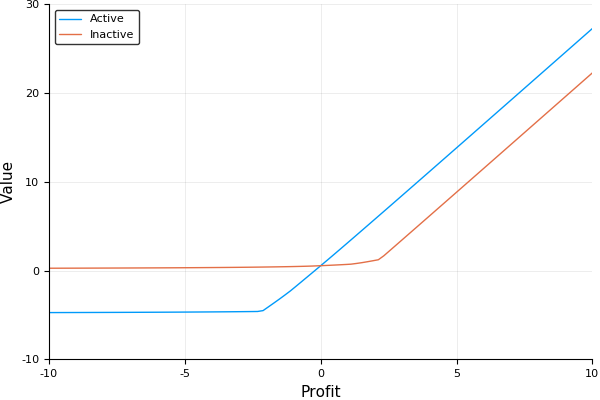

In [19]:
plot(IE2.p_vec, [V_computed2 U_computed2], label=["Active" "Inactive"],
     xlabel="Profit", ylabel="Value", ylims=(-10, 30), yticks=-10:10:30)

予想通り、前期操業していた場合はほぼ変わらず、前期操業していなかった場合に今期操業する閾値が小さくなっている